# Sentiment Analysis - Amazon Alexa Review

In [1]:
## importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
!pip install wordcloud
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
!pip install xgboost
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Exploratory Data Analysis

In [2]:
data = pd.read_csv(r'/content/sample_data/amazon_alexa.tsv', delimiter ='\t', quoting=3 )
print(data.shape)

(3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
## Columns
print(data.columns.values)

['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
## Checking null values
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [6]:
## Record with null value in  column verified_reviews
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
## Dropping the null record
data.dropna(inplace=True)

In [8]:
## Creating a column which has len of review
data['len_reviews'] = data['verified_reviews'].apply(len)

In [9]:
data.head()

,rating,date,variation,verified_reviews,feedback,len_reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [10]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
len_reviews,int64


In [11]:
data[data.duplicated(subset = 'verified_reviews')]

,rating,date,variation,verified_reviews,feedback,len_reviews
101,5,30-Jul-18,Heather Gray Fabric,Love it!,1,8
151,5,30-Jul-18,Sandstone Fabric,Love it,1,7
183,3,29-Jul-18,Heather Gray Fabric,,1,1
219,5,29-Jul-18,Sandstone Fabric,,1,1
220,5,29-Jul-18,Heather Gray Fabric,Cool,1,4
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


In [12]:
## Analyzing rating column
rating_counts = data['rating'].value_counts()
rating_counts

,count
rating,
5,2286
4,455
1,161
3,152
2,95


<function matplotlib.pyplot.show(close=None, block=None)>

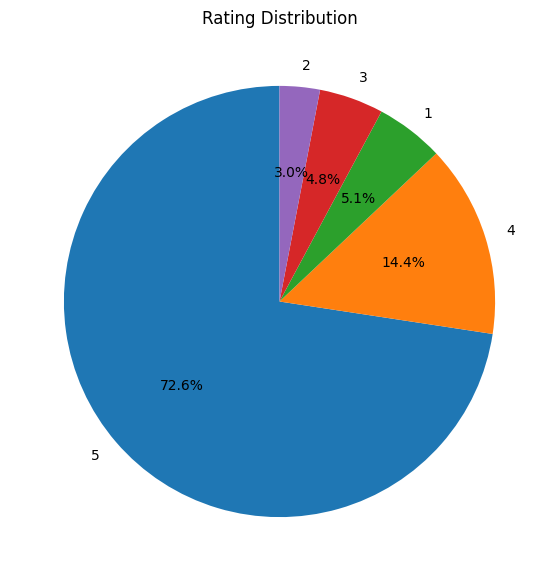

In [13]:
## Plotting the rating column in pie chart
fig = plt.figure(figsize=(7,7))
plt.pie(rating_counts, labels = rating_counts.index, autopct=lambda p: f'{p:.1f}%', startangle=90)
plt.title('Rating Distribution')
plt.show

In [14]:
## Analyzing feedback column
feedback_counts = data['feedback'].value_counts()
feedback_counts

,count
feedback,
1,2893
0,256


In [15]:
feedback1 = data[data['feedback']==1].iloc[1:10]['verified_reviews']
feedback1

,verified_reviews
1,Loved it!
2,"""Sometimes while playing a game, you can answe..."
3,"""I have had a lot of fun with this thing. My 4..."
4,Music
5,"""I received the echo as a gift. I needed anoth..."
6,"""Without having a cellphone, I cannot use many..."
7,I think this is the 5th one I've purchased. I'...
8,looks great
9,"""Love it! I’ve listened to songs I haven’t hea..."


In [16]:
feedback0 = data[data['feedback']==0].iloc[1:10]['verified_reviews']
feedback0

,verified_reviews
111,Sound is terrible if u want good music too get...
141,Not much features.
162,"""Stopped working after 2 weeks ,didn't follow ..."
176,Sad joke. Worthless.
187,"""Really disappointed Alexa has to be plug-in t..."
205,It's got great sound and bass but it doesn't w...
233,"""I am not super impressed with Alexa. When my ..."
299,Too difficult to set up. It keeps timing out ...
341,Alexa hardly came on..


We could see feedback1 has positive reviews and feedback0 has negative reviews

In [17]:
## Feedback distribution in percentage
print(f"Feedback - percentage distribution:', \n {round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback - percentage distribution:', 
 feedback
1    91.87
0     8.13
Name: count, dtype: float64


In [18]:
## Ratings for negative feedback
data[data['feedback']==0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [19]:
## Ratings for positive feedback
data[data['feedback']==1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


When ratings are 1 and 2, the feedback is negative(0) and for ratings 3, 4 and 5, the feedback is positive(1)

In [20]:
## Analyzing variation columns
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


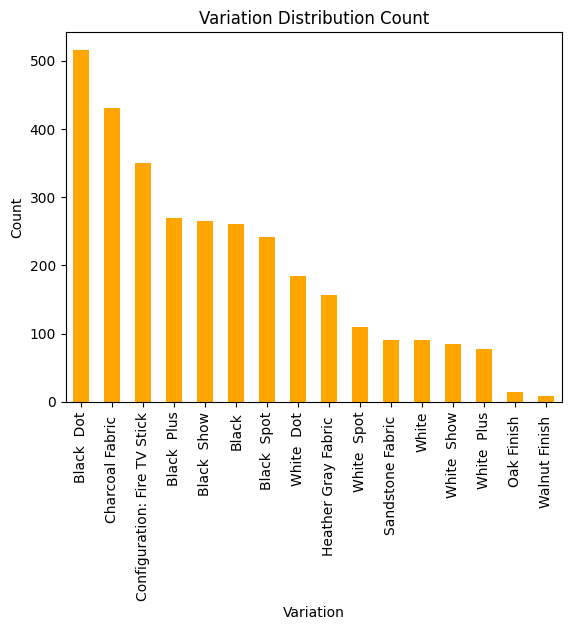

In [21]:
## Bar graph for Visualization
data['variation'].value_counts().plot.bar(color='orange')
plt.title('Variation Distribution Count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [22]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


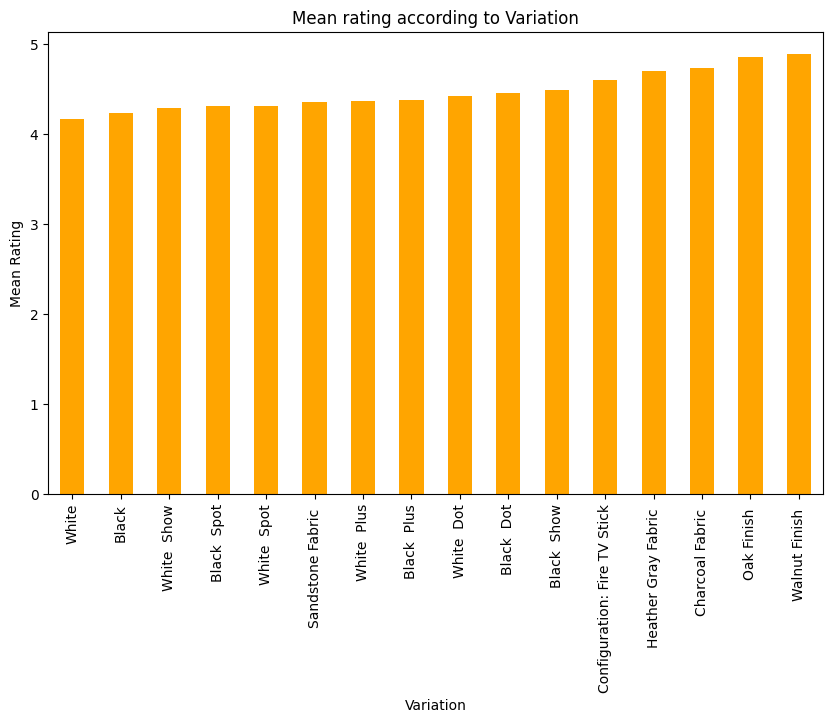

In [23]:
## Bar graph for Visualization
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='orange', figsize=(10,6))
plt.title('Mean rating according to Variation')
plt.xlabel('Variation')
plt.ylabel('Mean Rating')
plt.show()

In [24]:
## Analyzing len_reviews column which is the count of verified_reviews
data['len_reviews'].describe()

,len_reviews
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'Distribution of length review')]

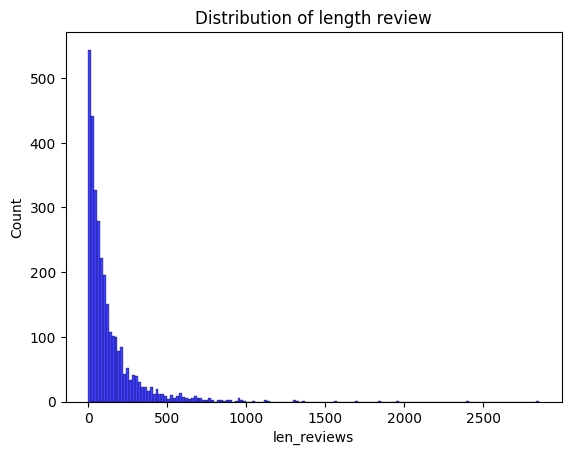

In [25]:
sns.histplot(data['len_reviews'],color = 'blue').set(title='Distribution of length review')

In [26]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data.verified_reviews)

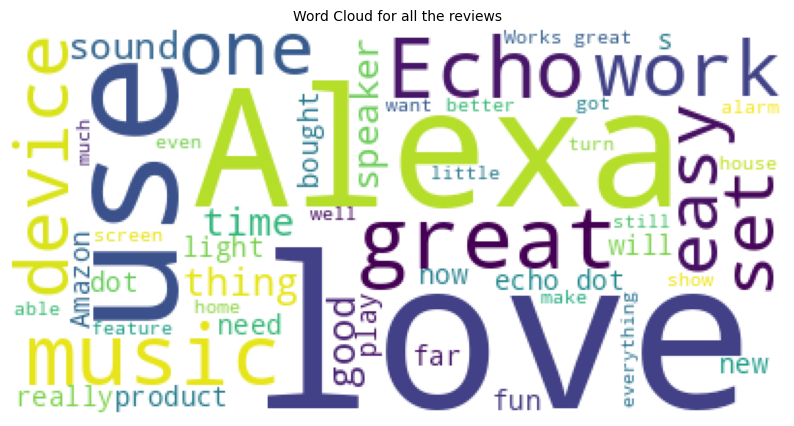

In [27]:
## Combining all reviews tom make Word Cloud
reviews = " ".join([review for review in data["verified_reviews"]])

wc = WordCloud(background_color='white', max_words=50)

## Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title("Word Cloud for all the reviews", fontsize=10)
plt.axis('off')
plt.show()

  ## **Preprocessing and Modelling**
To build the corpus from the 'verified_reviews' we perform the following:

1.  Replace any non alphabetic character with space
2.  Convert to lower case and splitinto words
3.  Iterate over the individual word and if it is not a stopword then add the stemmed form of the word to the corpus





In [28]:
corpus = []
for i in range(0,data.shape[0]):
  review = re.sub('[^a-zA-Z]'," ", data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [ps.stem(word) for word in review if not word in sw]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create Bag of Words

In [29]:
cv = CountVectorizer(max_features=2500)

## Independent and dependent variable
X = cv.fit_transform(corpus).toarray()
y= data['feedback'].values

In [30]:
## Saving the Count Vectorizer
pickle.dump(cv, open('/content/sample_data/cv.pkl', 'wb'))

In [31]:
print(X.shape)
print(y.shape)

(3149, 2500)
(3149,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [33]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building

**Random Forest**

In [34]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [35]:
## Prediction
y_pred = model_rf.predict(X_test_scaled)

In [36]:
## Accuracy Score
print(f"Training Accuracy: {model_rf.score(X_train_scaled, y_train)}")
score = accuracy_score(y_test,y_pred)
print(f"Prediction Accuracy: {score}")

Training Accuracy: 0.9927404718693285
Prediction Accuracy: 0.926984126984127


In [37]:
## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

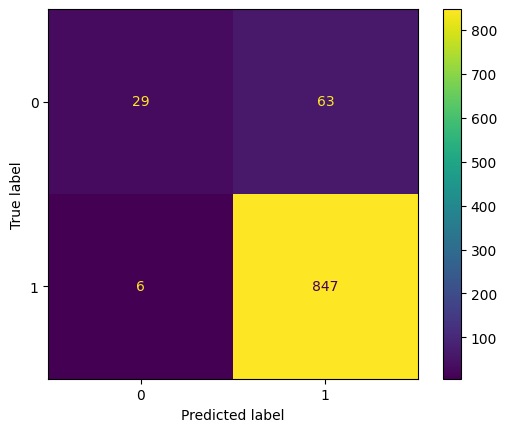

In [38]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model_rf.classes_)
cm_display.plot()
plt.show()

In [39]:
## Hyperparameter tuning
params = {
    'n_estimators':[100,300],
    'criterion': ['gini', 'entropy'],
    'bootstrap' :[True],
    'max_depth' :[80,100],
    'min_samples_split': [8,12]
    }


In [40]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid=params, cv=cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scaled, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [80, 100], 'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [41]:
## Getting the best parameters from the grid search
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'criterion': 'gini', 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}


In [42]:
model_rf1 = RandomForestClassifier(bootstrap= True, criterion= 'gini', max_depth= 80, min_samples_split= 8, n_estimators= 300)
model_rf1.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=80, min_samples_split=8, n_estimators=300)

In [43]:
## Prediction
y_pred = model_rf1.predict(X_test_scaled)

In [44]:
## Accuracy Score
print(f"Training Accuracy: {model_rf1.score(X_train_scaled, y_train)}")
score = accuracy_score(y_test,y_pred)
print(f"Prediction Accuracy: {score}")

Training Accuracy: 0.9745916515426497
Prediction Accuracy: 0.9164021164021164


In [45]:
## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

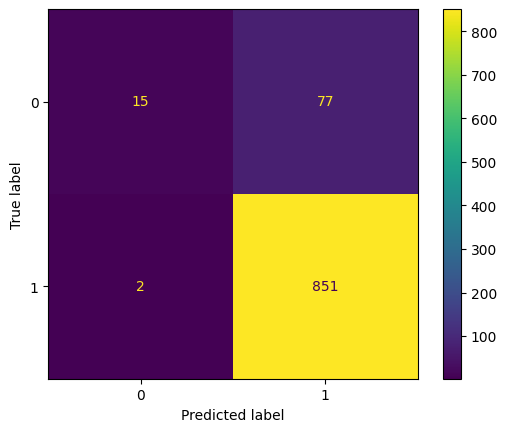

In [46]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model_rf.classes_)
cm_display.plot()
plt.show()

XGBoost

In [47]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [48]:
## Prediction
y_pred = model_xgb.predict(X_test_scaled)

In [49]:
## Accuracy Score
print(f"Training Accuracy: {model_xgb.score(X_train_scaled, y_train)}")
score = accuracy_score(y_test,y_pred)
print(f"Prediction Accuracy: {score}")

Training Accuracy: 0.9750453720508166
Prediction Accuracy: 0.9206349206349206


In [50]:
## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

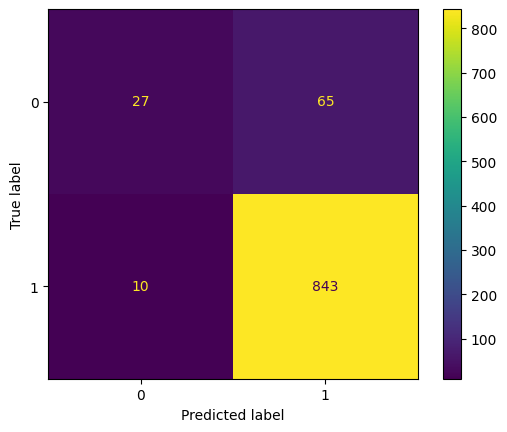

In [51]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model_xgb.classes_)
cm_display.plot()
plt.show()